In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.optim import  AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os

c:\Users\z47al\.conda\envs\ia_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configs
MODEL_NAME = "PlanTL-GOB-ES/roberta-base-bne"
RANDOM_STATE = 22
NUM_EPOCHS = 50
BATCH_SIZE = 16
KFOLDS = 5
PATIENCE = 5
TARGET_AUC = 0.93
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# establecer semilla
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [17]:
# Carga de datos
df = pd.read_csv("ds_BETO.csv")

In [4]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
# Model architecture
class RobertaClassifier(nn.Module):
    def __init__(self, unfreeze_layers=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        for name, param in self.bert.named_parameters():
            param.requires_grad = False
            
        if unfreeze_layers:
            for name, param in self.bert.named_parameters():
                if any(layer in name for layer in unfreeze_layers):
                    param.requires_grad = True

        self.dropout = nn.Dropout(0.5)
        self.intermediate = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = torch.mean(outputs.last_hidden_state, dim=1) # CLS token = outputs.last_hidden_state[:, 0, :] 
        x = self.dropout(x)
        x = self.relu(self.intermediate(x))
        x = self.classifier(x)
        return x.squeeze(-1)

In [6]:
# Training loop with cross-validation
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf.split(df["texto_bert"], df["class"])):
    print(f"\n----- Fold {fold+1} -----")

    train_texts = df.iloc[train_idx]["texto_bert"].tolist()
    train_labels = df.iloc[train_idx]["class"].tolist()
    val_texts = df.iloc[val_idx]["texto_bert"].tolist()
    val_labels = df.iloc[val_idx]["class"].tolist()

    train_dataset = TweetDataset(train_texts, train_labels)
    val_dataset = TweetDataset(val_texts, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = RobertaClassifier().to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = get_scheduler("linear", optimizer=optimizer,
                              num_warmup_steps=0,
                              num_training_steps=NUM_EPOCHS * len(train_loader))
    criterion = nn.BCEWithLogitsLoss()

    best_auc = 0
    patience_counter = 0

    train_loss_vals, val_auc_vals = [], []

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        train_loss_vals.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].cpu().numpy()
                outputs = model(input_ids, attention_mask)
                probs = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(probs)
                val_trues.extend(labels)

        val_auc = roc_auc_score(val_trues, val_preds)
        val_auc_vals.append(val_auc)
        print(f"Epoch {epoch+1}: Train Loss={train_loss_vals[-1]:.4f}, Val AUC={val_auc:.4f}")

        # Early stopping
        if val_auc > best_auc:
            best_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping.")
                break

              # Plot convergence
    plt.figure()
    plt.plot(train_loss_vals, label="Train Loss")
    plt.plot(val_auc_vals, label="Val AUC")
    plt.legend()
    plt.title(f"Fold {fold+1} - Training Progress")
    plt.savefig(f"fold{fold+1}_training_plot.png")
    plt.close()


----- Fold 1 -----


c:\Users\z47al\.conda\envs\ia_project\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\z47al\.cache\huggingface\hub\models--PlanTL-GOB-ES--roberta-base-bne. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta

Epoch 1: Train Loss=0.3972, Val AUC=0.9671


Epoch 2: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 2: Train Loss=0.1675, Val AUC=0.9684


Epoch 3: 100%|██████████| 75/75 [02:46<00:00,  2.21s/it]


Epoch 3: Train Loss=0.0896, Val AUC=0.9737


Epoch 4: 100%|██████████| 75/75 [02:44<00:00,  2.20s/it]


Epoch 4: Train Loss=0.0524, Val AUC=0.9735


Epoch 5: 100%|██████████| 75/75 [02:45<00:00,  2.20s/it]


Epoch 5: Train Loss=0.0238, Val AUC=0.9775


Epoch 6: 100%|██████████| 75/75 [03:07<00:00,  2.51s/it]


Epoch 6: Train Loss=0.0306, Val AUC=0.9757


Epoch 7: 100%|██████████| 75/75 [04:12<00:00,  3.37s/it]


Epoch 7: Train Loss=0.0098, Val AUC=0.9759


Epoch 8: 100%|██████████| 75/75 [02:50<00:00,  2.28s/it]


Epoch 8: Train Loss=0.0063, Val AUC=0.9758


Epoch 9: 100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Epoch 9: Train Loss=0.0049, Val AUC=0.9757


Epoch 10: 100%|██████████| 75/75 [02:41<00:00,  2.16s/it]


Epoch 10: Train Loss=0.0041, Val AUC=0.9760
Early stopping.

----- Fold 2 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 1: Train Loss=0.4076, Val AUC=0.9451


Epoch 2: 100%|██████████| 75/75 [02:45<00:00,  2.20s/it]


Epoch 2: Train Loss=0.1648, Val AUC=0.9694


Epoch 3: 100%|██████████| 75/75 [02:44<00:00,  2.20s/it]


Epoch 3: Train Loss=0.1022, Val AUC=0.9575


Epoch 4: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 4: Train Loss=0.0555, Val AUC=0.9735


Epoch 5: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 5: Train Loss=0.0272, Val AUC=0.9695


Epoch 6: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 6: Train Loss=0.0158, Val AUC=0.9748


Epoch 7: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 7: Train Loss=0.0087, Val AUC=0.9696


Epoch 8: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 8: Train Loss=0.0064, Val AUC=0.9710


Epoch 9: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 9: Train Loss=0.0051, Val AUC=0.9714


Epoch 10: 100%|██████████| 75/75 [02:48<00:00,  2.24s/it]


Epoch 10: Train Loss=0.0041, Val AUC=0.9712


Epoch 11: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 11: Train Loss=0.0035, Val AUC=0.9713
Early stopping.

----- Fold 3 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:32<00:00,  2.04s/it]


Epoch 1: Train Loss=0.4165, Val AUC=0.9582


Epoch 2: 100%|██████████| 75/75 [02:35<00:00,  2.08s/it]


Epoch 2: Train Loss=0.1531, Val AUC=0.9690


Epoch 3: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it]


Epoch 3: Train Loss=0.0771, Val AUC=0.9713


Epoch 4: 100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


Epoch 4: Train Loss=0.0659, Val AUC=0.9732


Epoch 5: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it]


Epoch 5: Train Loss=0.0280, Val AUC=0.9722


Epoch 6: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it]


Epoch 6: Train Loss=0.0217, Val AUC=0.9664


Epoch 7: 100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


Epoch 7: Train Loss=0.0216, Val AUC=0.9698


Epoch 8: 100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


Epoch 8: Train Loss=0.0138, Val AUC=0.9474


Epoch 9: 100%|██████████| 75/75 [02:31<00:00,  2.03s/it]


Epoch 9: Train Loss=0.0054, Val AUC=0.9688
Early stopping.

----- Fold 4 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:47<00:00,  2.23s/it]


Epoch 1: Train Loss=0.4413, Val AUC=0.9583


Epoch 2: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 2: Train Loss=0.1987, Val AUC=0.9685


Epoch 3: 100%|██████████| 75/75 [02:47<00:00,  2.23s/it]


Epoch 3: Train Loss=0.0905, Val AUC=0.9697


Epoch 4: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 4: Train Loss=0.0553, Val AUC=0.9636


Epoch 5: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 5: Train Loss=0.0298, Val AUC=0.9648


Epoch 6: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 6: Train Loss=0.0309, Val AUC=0.9648


Epoch 7: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 7: Train Loss=0.0225, Val AUC=0.9519


Epoch 8: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 8: Train Loss=0.0118, Val AUC=0.9514
Early stopping.

----- Fold 5 -----


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 75/75 [02:44<00:00,  2.19s/it]


Epoch 1: Train Loss=0.4377, Val AUC=0.9646


Epoch 2: 100%|██████████| 75/75 [02:42<00:00,  2.16s/it]


Epoch 2: Train Loss=0.1895, Val AUC=0.9756


Epoch 3: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 3: Train Loss=0.0925, Val AUC=0.9723


Epoch 4: 100%|██████████| 75/75 [02:41<00:00,  2.16s/it]


Epoch 4: Train Loss=0.0467, Val AUC=0.9567


Epoch 5: 100%|██████████| 75/75 [02:45<00:00,  2.21s/it]


Epoch 5: Train Loss=0.0351, Val AUC=0.9740


Epoch 6: 100%|██████████| 75/75 [02:43<00:00,  2.18s/it]


Epoch 6: Train Loss=0.0161, Val AUC=0.9770


Epoch 7: 100%|██████████| 75/75 [02:42<00:00,  2.17s/it]


Epoch 7: Train Loss=0.0117, Val AUC=0.9779


Epoch 8: 100%|██████████| 75/75 [03:34<00:00,  2.86s/it]


Epoch 8: Train Loss=0.0106, Val AUC=0.9777


Epoch 9: 100%|██████████| 75/75 [04:04<00:00,  3.27s/it]


Epoch 9: Train Loss=0.0081, Val AUC=0.9782


Epoch 10: 100%|██████████| 75/75 [04:04<00:00,  3.26s/it]


Epoch 10: Train Loss=0.0046, Val AUC=0.9744


Epoch 11: 100%|██████████| 75/75 [04:02<00:00,  3.24s/it]


Epoch 11: Train Loss=0.0038, Val AUC=0.9740


Epoch 12: 100%|██████████| 75/75 [02:37<00:00,  2.10s/it]


Epoch 12: Train Loss=0.0033, Val AUC=0.9737


Epoch 13: 100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch 13: Train Loss=0.0029, Val AUC=0.9733


Epoch 14: 100%|██████████| 75/75 [02:39<00:00,  2.13s/it]


Epoch 14: Train Loss=0.0025, Val AUC=0.9738
Early stopping.


# Gráficas del desempeño del modelo

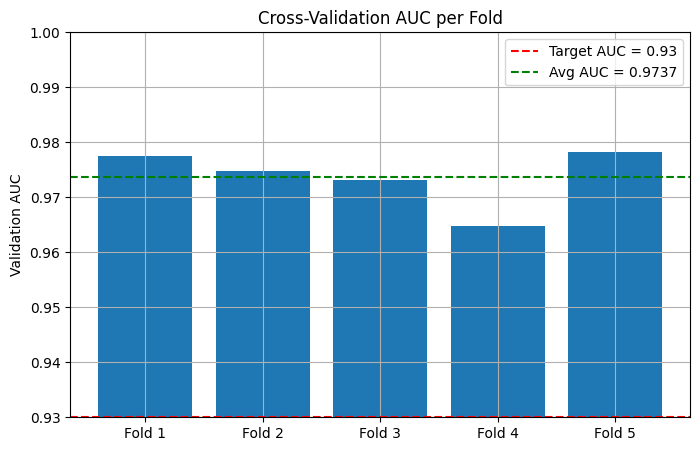

In [8]:
fold_aucs = [0.9775, 0.9748, 0.9732, 0.9648, 0.9782]
average_auc = np.mean(fold_aucs)

plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), fold_aucs, tick_label=[f'Fold {i}' for i in range(1, 6)])
plt.axhline(y=0.93, color='r', linestyle='--', label='Target AUC = 0.93')
plt.axhline(y=average_auc, color='g', linestyle='--', label=f'Avg AUC = {average_auc:.4f}')
plt.ylim(0.93, 1.0)
plt.ylabel('Validation AUC')
plt.title('Cross-Validation AUC per Fold')
plt.legend()
plt.grid(True)
plt.show()

# Entrenamiento

In [6]:
# Carga de datos y separacion de columnas para entrenamiento
df_train = pd.read_csv("ds_BETO.csv")

In [8]:
train_df, val_df = train_test_split(df_train, test_size=0.1, stratify=df_train["class"], random_state=RANDOM_STATE)

In [9]:
# Uso de funciones
dataset_train = TweetDataset(train_df["texto_bert"].tolist(), train_df["class"].tolist())
dataset_val = TweetDataset(val_df["texto_bert"].tolist(), val_df["class"].tolist())
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE)

In [12]:
model_final = RobertaClassifier(unfreeze_layers=["encoder.layer.11", "encoder.layer.10"]).to(DEVICE)
optimizer = AdamW(model_final.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()
scheduler_final = ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.5, patience=2)
# scheduler = get_scheduler("linear", 
#                           optimizer=optimizer,
#                           num_warmup_steps=0, 
#                           num_training_steps=NUM_EPOCHS * len(loader_train)
#                           )

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Training loop
best_auc = 0
patience_counter = 0
train_loss_vals, val_auc_vals = [], []

for epoch in range(NUM_EPOCHS):
    model_final.train()
    
    total_loss = 0

    for batch in tqdm(loader_train, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model_final(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        total_loss += loss.item()
        
    
    avg_loss_train = total_loss / len(loader_train)    
    train_loss_vals.append(avg_loss_train)
    
    model_final.eval()
    val_trues, val_preds = [], []
    with torch.no_grad():
        for batch in loader_val:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels =  batch["labels"].cpu().numpy()
            outputs = model_final(input_ids, attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            val_preds.extend(probs)
            val_trues.extend(labels)

    auc_val = roc_auc_score(val_trues, val_preds)
    f1_val = f1_score(val_trues, np.array(val_preds) > 0.5)
    val_auc_vals.append(auc_val)
    scheduler_final.step(auc_val)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss_train:.4f}, Validation AUC = {auc_val:.4f}, F1 Score = {f1_val:.4f}")

    if auc_val > best_auc:
        best_auc = auc_val
        patience_counter = 0
        torch.save(model_final.state_dict(), "final_best_model.pt")
        print("Modelo guardado!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping")
            break

Epoch 1: 100%|██████████| 85/85 [01:11<00:00,  1.19it/s]


Epoch 1: Train Loss = 0.5670, Validation AUC = 0.9036, F1 Score = 0.8848
Modelo guardado!


Epoch 2: 100%|██████████| 85/85 [01:10<00:00,  1.21it/s]


Epoch 2: Train Loss = 0.3103, Validation AUC = 0.9345, F1 Score = 0.9157
Modelo guardado!


Epoch 3: 100%|██████████| 85/85 [01:13<00:00,  1.16it/s]


Epoch 3: Train Loss = 0.2222, Validation AUC = 0.9482, F1 Score = 0.9202
Modelo guardado!


Epoch 4: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 4: Train Loss = 0.1809, Validation AUC = 0.9527, F1 Score = 0.8987
Modelo guardado!


Epoch 5: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 5: Train Loss = 0.1446, Validation AUC = 0.9536, F1 Score = 0.9136
Modelo guardado!


Epoch 6: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]


Epoch 6: Train Loss = 0.1039, Validation AUC = 0.9559, F1 Score = 0.8961
Modelo guardado!


Epoch 7: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 7: Train Loss = 0.0748, Validation AUC = 0.9566, F1 Score = 0.9317
Modelo guardado!


Epoch 8: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 8: Train Loss = 0.0496, Validation AUC = 0.9536, F1 Score = 0.9045


Epoch 9: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 9: Train Loss = 0.0384, Validation AUC = 0.9521, F1 Score = 0.8816


Epoch 10: 100%|██████████| 85/85 [01:10<00:00,  1.21it/s]


Epoch 10: Train Loss = 0.0340, Validation AUC = 0.9555, F1 Score = 0.9202


Epoch 11: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]


Epoch 11: Train Loss = 0.0195, Validation AUC = 0.9546, F1 Score = 0.9250


Epoch 12: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 12: Train Loss = 0.0157, Validation AUC = 0.9566, F1 Score = 0.9193
Modelo guardado!


Epoch 13: 100%|██████████| 85/85 [01:09<00:00,  1.21it/s]


Epoch 13: Train Loss = 0.0136, Validation AUC = 0.9563, F1 Score = 0.9125


Epoch 14: 100%|██████████| 85/85 [01:10<00:00,  1.21it/s]


Epoch 14: Train Loss = 0.0122, Validation AUC = 0.9570, F1 Score = 0.9193
Modelo guardado!


Epoch 15: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]


Epoch 15: Train Loss = 0.0106, Validation AUC = 0.9575, F1 Score = 0.9193
Modelo guardado!


Epoch 16: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]


Epoch 16: Train Loss = 0.0102, Validation AUC = 0.9575, F1 Score = 0.9125


Epoch 17: 100%|██████████| 85/85 [01:10<00:00,  1.21it/s]


Epoch 17: Train Loss = 0.0090, Validation AUC = 0.9570, F1 Score = 0.9114


Epoch 18: 100%|██████████| 85/85 [01:09<00:00,  1.22it/s]


Epoch 18: Train Loss = 0.0085, Validation AUC = 0.9566, F1 Score = 0.9057


Epoch 19: 100%|██████████| 85/85 [01:10<00:00,  1.20it/s]


Epoch 19: Train Loss = 0.0069, Validation AUC = 0.9571, F1 Score = 0.9057


Epoch 20: 100%|██████████| 85/85 [01:11<00:00,  1.19it/s]


Epoch 20: Train Loss = 0.0061, Validation AUC = 0.9564, F1 Score = 0.9057
Early stopping


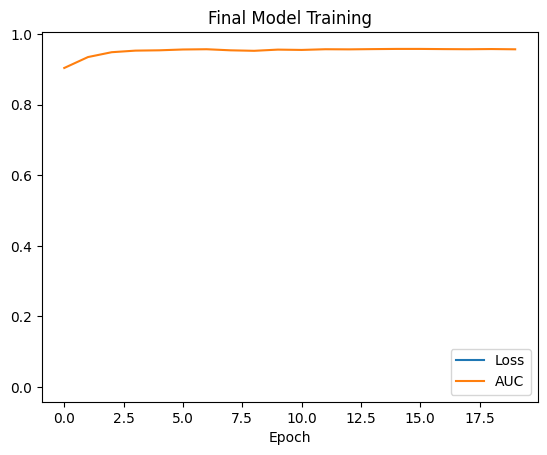

In [14]:
# Plot training performance
plt.figure()
plt.plot(avg_loss_train, label="Loss")
plt.plot(val_auc_vals, label="AUC")
plt.xlabel("Epoch")
plt.title("Final Model Training")
plt.legend()
plt.savefig("final_model_training_plot.png")
plt.show()

# Prueba

In [15]:
df_test = pd.read_csv("ds_BETO_TEST.csv")
texts_test = df_test["texto_bert"].tolist()
labels_test = df_test["class"].tolist()

In [16]:
dataset_test = TweetDataset(texts_test, labels_test)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [17]:
model_final.load_state_dict(torch.load("final_best_model.pt"))
model_final.eval()

RobertaClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [23]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

In [19]:
y_true, y_probs = [], []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].cpu().numpy()

        outputs = model_final(input_ids, attention_mask)
        probs = torch.sigmoid(outputs).cpu().numpy()

        y_probs.extend(probs)
        y_true.extend(labels)

y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = (y_probs >= 0.5).astype(int)

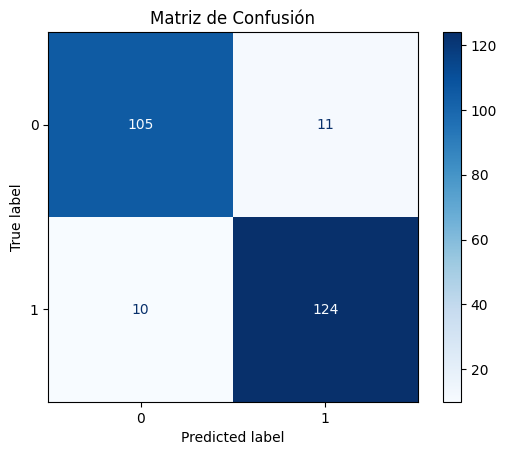

In [24]:
auc_score = roc_auc_score(y_true, y_probs)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fpr, tpr, tresholds = roc_curve(y_true, y_probs)

disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()

AUC: 0.9548
F1 Score: 0.9219


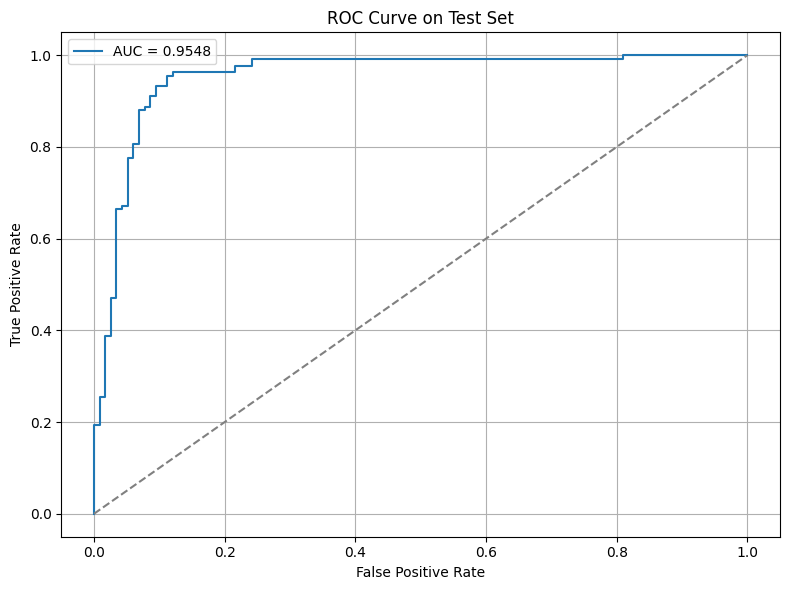

In [25]:
print(f"AUC: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("roc_curve_test_set.png")
plt.show()